In [3]:


# Cell 1: Imports and Constants
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Define constants
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 15
NUM_CLASSES = 6
CLASS_NAMES = ['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

# Set your dataset paths here
TRAIN_DIR = "D:/Sem 6/ICV/ICV_Project/dataset/train"  
TEST_DIR = "D:/Sem 6/ICV/ICV_Project/dataset/test"   

In [ ]:
# Cell 2: Preprocessing Functions
def load_and_preprocess_image(image_path):
    """Load and preprocess a single image."""
    # Read image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error loading image: {image_path}")
        return None
    
    # Convert from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Apply histogram equalization to enhance contrast
    img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    
    # Resize to standard dimensions
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    
    # Normalize pixel values
    img = img / 255.0
    
    return img

def edge_detection_visualization(image_path):
    """Apply edge detection to visualize damage features."""
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)
    
    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw contours on original image
    contour_img = img.copy()
    cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)
    
    # Display results
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Original')
    plt.subplot(2, 2, 2), plt.imshow(gray, cmap='gray'), plt.title('Grayscale')
    plt.subplot(2, 2, 3), plt.imshow(edges, cmap='gray'), plt.title('Edges')
    plt.subplot(2, 2, 4), plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB)), plt.title('Contours')
    plt.tight_layout()
    plt.show()
    

In [ ]:
# Cell 3: Model Building Function
def build_model():
    """Build a CNN model using transfer learning with VGG16."""
    # Use a pre-trained model as feature extractor
    base_model = applications.MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )
    
    # Freeze the base model layers
    base_model.trainable = False
    
    # Create the model architecture
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [ ]:
# Cell 4: Data Generator Function
def prepare_data_generators(train_dir=TRAIN_DIR, test_dir=TEST_DIR):
    """Prepare data generators for training and validation."""
    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2  # 20% of training data for validation
    )
    
    # Only rescaling for testing
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    # Load training data with validation split
    train_generator = train_datagen.flow_from_directory(
        train_dir,  # Use the parameter instead of hardcoded path
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training'
    )
    
    validation_generator = train_datagen.flow_from_directory(
        train_dir,  # Use the parameter instead of hardcoded path
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation'
    )
    
    # Load test data
    test_generator = test_datagen.flow_from_directory(
        test_dir,  # Use the parameter instead of hardcoded path
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    return train_generator, validation_generator, test_generator

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,051,846 (11.64 MB)

 Trainable params: 791,302 (3.02 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

Found 1470 images belonging to 6 classes.
Found 366 images belonging to 6 classes.
Found 460 images belonging to 6 classes.
Epoch 1/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3414 - loss: 1.9684

45/45 ━━━━━━━━━━━━━━━━━━━━ 303s 6s/step - accuracy: 0.3433 - loss: 1.9613 - val_accuracy: 0.4688 - val_loss: 1.3105
Epoch 2/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 947ms/step - accuracy: 0.6250 - loss: 1.2197 - val_accuracy: 0.4602 - val_loss: 1.3204
Epoch 3/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5979 - loss: 1.0740

45/45 ━━━━━━━━━━━━━━━━━━━━ 212s 5s/step - accuracy: 0.5976 - loss: 1.0745 - val_accuracy: 0.4858 - val_loss: 1.1254
Epoch 4/15
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2:18 3s/step - accuracy: 0.5938 - loss: 0.8762

45/45 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.5938 - loss: 0.8762 - val_accuracy: 0.5256 - val_loss: 1.0989
Epoch 5/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 203s 5s/step - accuracy: 0.5998 - loss: 1.0352 - val_accuracy: 0.5085 - val_loss: 1.0482
Epoch 6/15
 1/45 ━━━━━━━━━━━━━━━━━━━━ 3:01 4s/step - accuracy: 0.5625 - loss: 1.1190

45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 888ms/step - accuracy: 0.5625 - loss: 1.1190 - val_accuracy: 0.5398 - val_loss: 1.0506
Epoch 7/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 216s 4s/step - accuracy: 0.6455 - loss: 0.8559 - val_accuracy: 0.5256 - val_loss: 1.0114
Epoch 8/15
 1/45 ━━━━━━━━━━━━━━━━━━━━ 1:49 2s/step - accuracy: 0.6875 - loss: 0.9687

45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 892ms/step - accuracy: 0.6875 - loss: 0.9687 - val_accuracy: 0.5653 - val_loss: 0.9996
Epoch 9/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6793 - loss: 0.8264

45/45 ━━━━━━━━━━━━━━━━━━━━ 189s 4s/step - accuracy: 0.6789 - loss: 0.8269 - val_accuracy: 0.5938 - val_loss: 0.9601
Epoch 10/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 865ms/step - accuracy: 0.6875 - loss: 0.8489 - val_accuracy: 0.5881 - val_loss: 0.9422
Epoch 11/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 219s 5s/step - accuracy: 0.6949 - loss: 0.7602 - val_accuracy: 0.5483 - val_loss: 0.9750
Epoch 12/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.6250 - loss: 1.1495 - val_accuracy: 0.5653 - val_loss: 0.9612
Epoch 13/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 207s 5s/step - accuracy: 0.7058 - loss: 0.7018 - val_accuracy: 0.5881 - val_loss: 0.8804
Epoch 14/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.7000 - loss: 0.8127 - val_accuracy: 0.5881 - val_loss: 0.9268
Epoch 15/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 201s 4s/step - accuracy: 0.7285 - loss: 0.6704 - val_accuracy: 0.5824 - val_loss: 0.9647


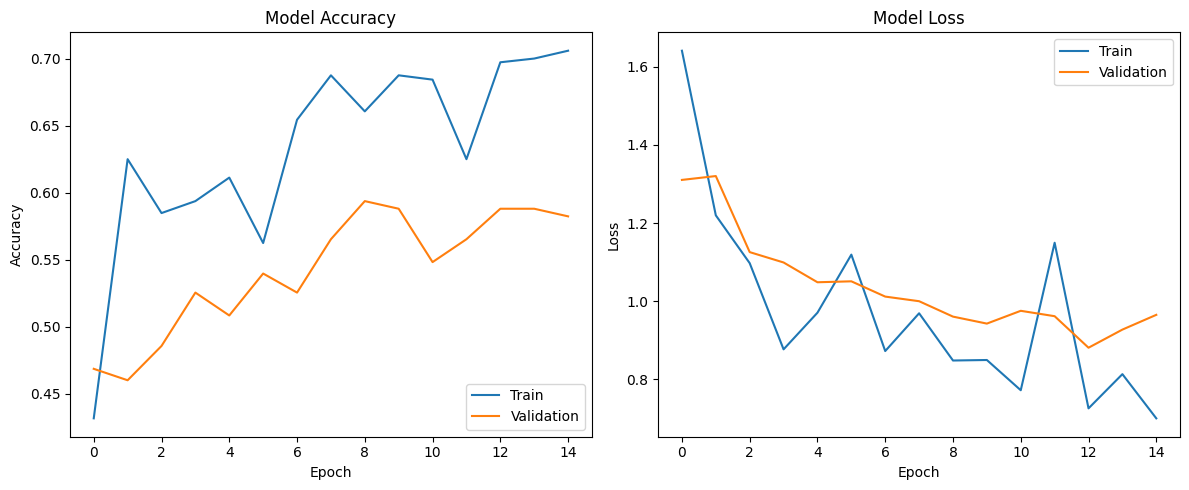

In [ ]:
# Cell 5: Model Training (ONLY RUN WHEN YOU WANT TO TRAIN)
# Comment out this cell after training once

# Build the model
model = build_model()
model.summary()

# Prepare data generators
train_generator, validation_generator, test_generator = prepare_data_generators()

# Create callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'car_damage_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping, checkpoint]
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()


In [ ]:
# Cell 6: Load Trained Model
# Run this instead of training once you have a saved model
model_path = 'car_damage_model.h5'

if os.path.exists(model_path):
    print(f"Loading pre-trained model from {model_path}...")
    model = tf.keras.models.load_model(model_path)
    
    #ADDED LATER
    # Force the model to build by making a dummy prediction
    dummy_input = np.zeros((1, IMG_HEIGHT, IMG_WIDTH, 3))
    _ = model.predict(dummy_input)
    
    print("Model loaded successfully!")
else:
    print(f"No model found at {model_path}. Please train the model first.")

Loading pre-trained model from car_damage_model.h5...


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Model loaded successfully!


Found 1470 images belonging to 6 classes.
Found 366 images belonging to 6 classes.
Found 460 images belonging to 6 classes.


d:\Sem 6\ICV\ICV_Project\vscode\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step - accuracy: 0.7019 - loss: 0.7162
Test accuracy: 0.6935
Test loss: 0.6678
15/15 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step

Classification Report:
              precision    recall  f1-score   support

  F_Breakage       0.76      0.72      0.74       100
   F_Crushed       0.65      0.51      0.57        80
    F_Normal       0.79      1.00      0.88       100
  R_Breakage       0.48      0.27      0.34        60
   R_Crushed       0.50      0.55      0.52        60
    R_Normal       0.74      0.95      0.83        60

    accuracy                           0.69       460
   macro avg       0.65      0.67      0.65       460
weighted avg       0.68      0.69      0.67       460



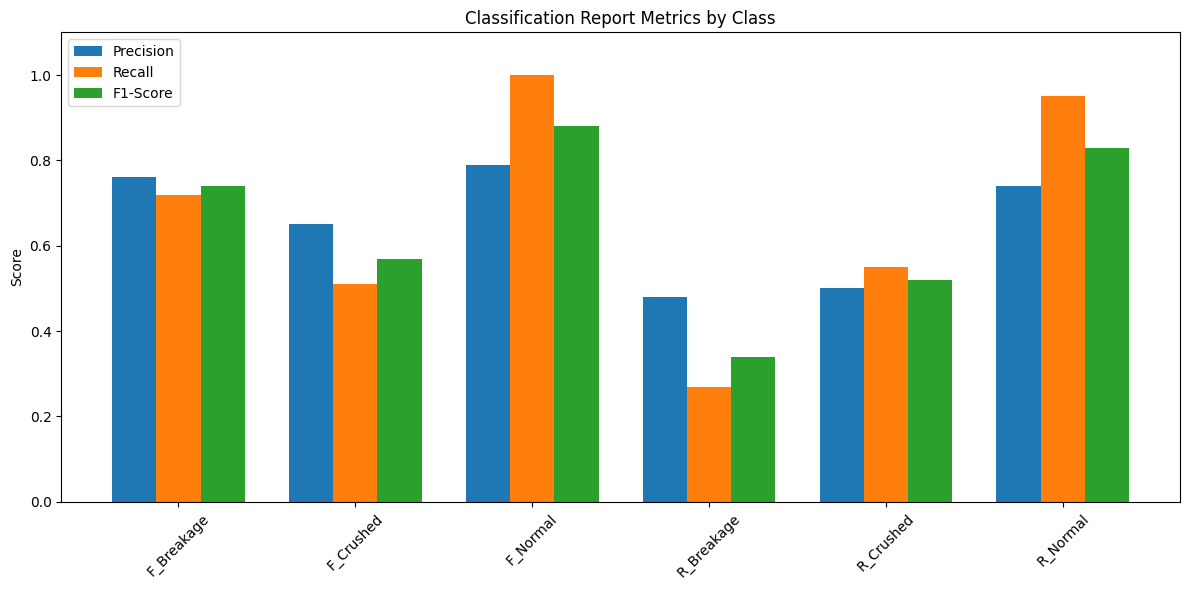

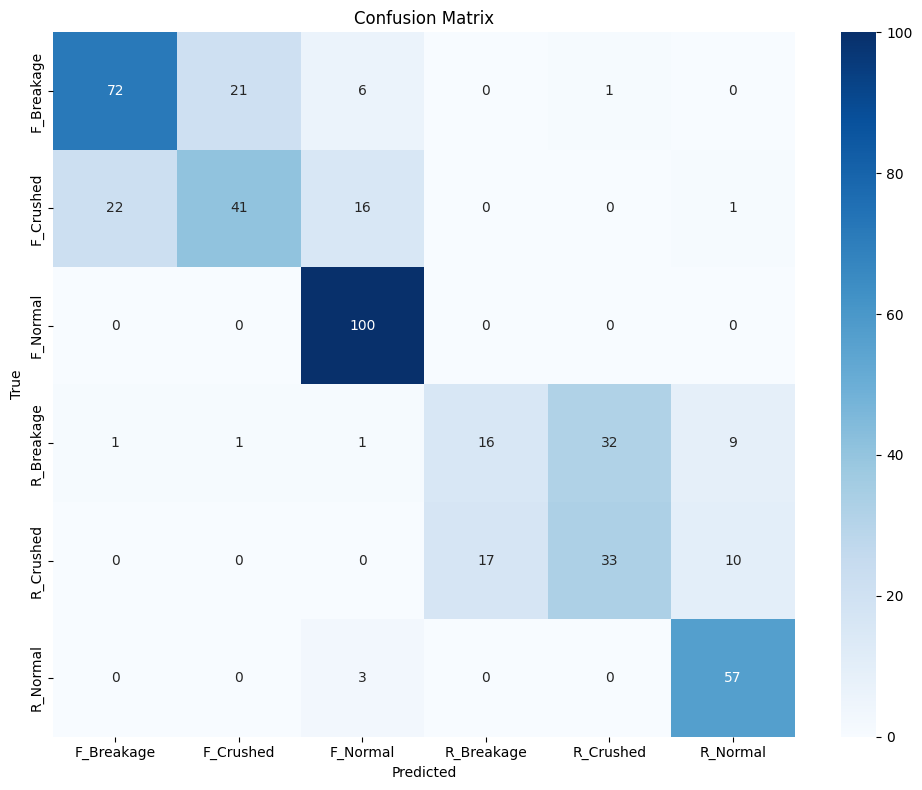

In [ ]:
# Cell 7: Evaluate Model
# Only run after loading or training a model
if 'model' in locals():
    # Prepare test data generator
    _, _, test_generator = prepare_data_generators()
    
    # Evaluate model performance
    test_loss, test_acc = model.evaluate(test_generator)
    print(f'Test accuracy: {test_acc:.4f}')
    print(f'Test loss: {test_loss:.4f}')
    
    # Get predictions
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))
    
    # Class labels
    classes = ['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

    # Metrics from your classification report
    precision = [0.76, 0.65, 0.79, 0.48, 0.50, 0.74]
    recall    = [0.72, 0.51, 1.00, 0.27, 0.55, 0.95]
    f1_score  = [0.74, 0.57, 0.88, 0.34, 0.52, 0.83]

    # Set position of bars on X axis
    x = np.arange(len(classes))
    width = 0.25

    # Create bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(x - width, precision, width=width, label='Precision')
    plt.bar(x, recall, width=width, label='Recall')
    plt.bar(x + width, f1_score, width=width, label='F1-Score')

    # Customization
    plt.xticks(x, classes, rotation=45)
    plt.ylabel('Score')
    plt.ylim(0, 1.1)
    plt.title('Classification Report Metrics by Class')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
     
    # Confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
else:
    print("No model loaded. Please train or load a model first.")

Found 1470 images belonging to 6 classes.
Found 366 images belonging to 6 classes.
Found 460 images belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


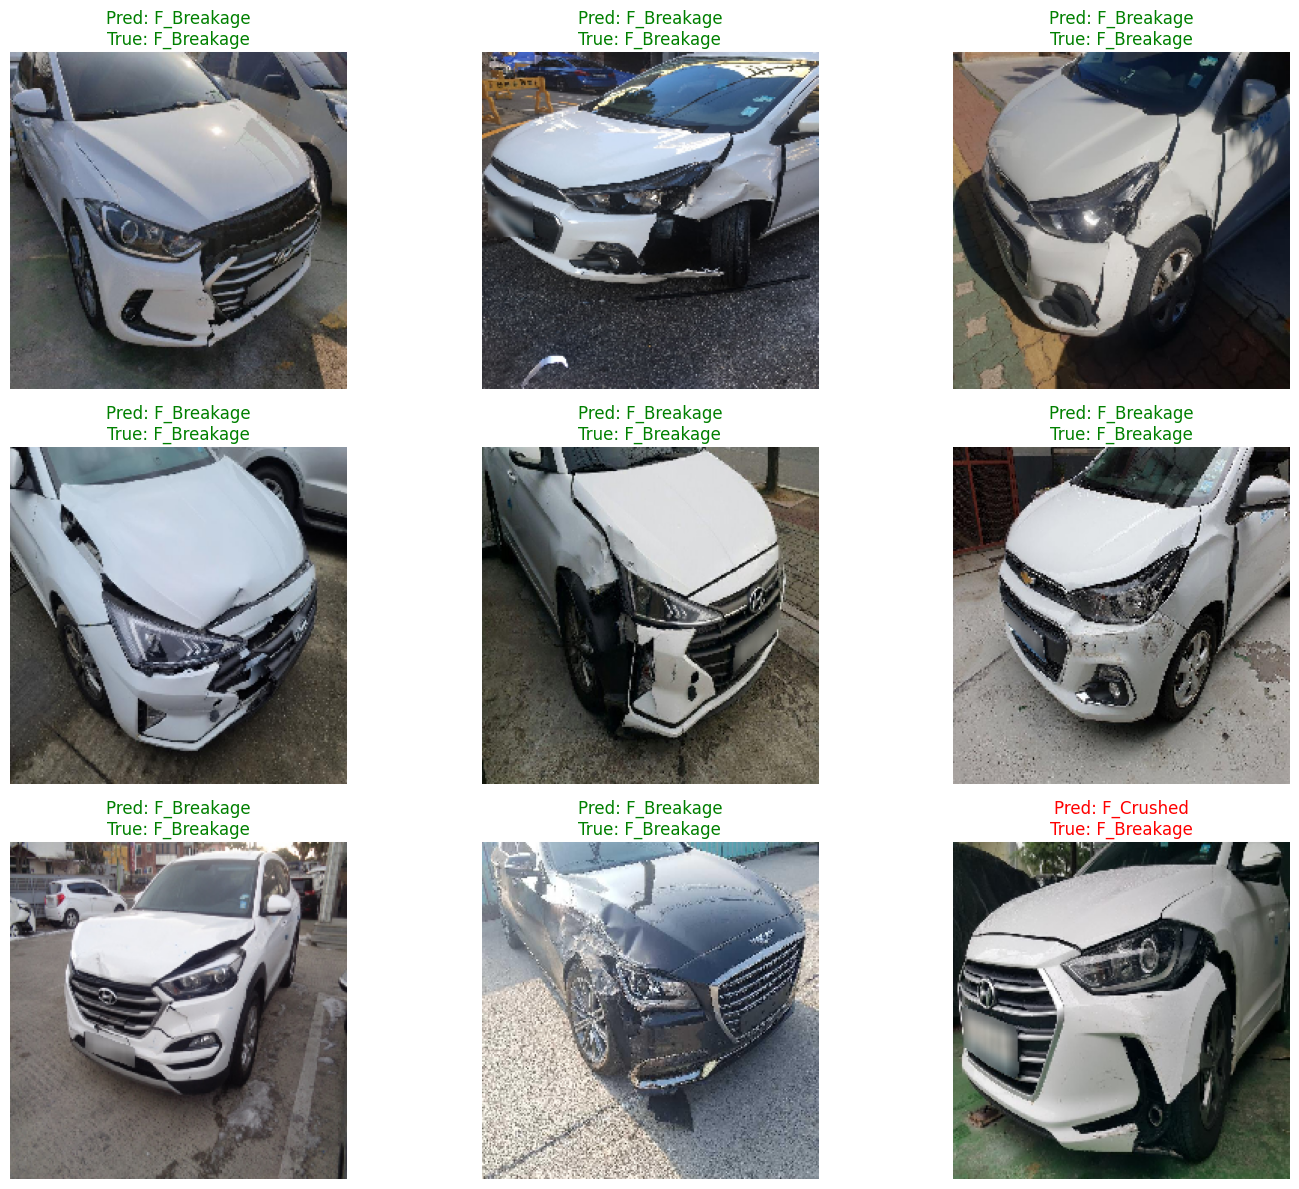

In [ ]:
# Cell 8: Visualize Predictions
def visualize_predictions(model, test_generator):
    """Visualize some predictions from the model."""
    # Get a batch of test images
    test_images, test_labels = next(test_generator)
    
    # Make predictions
    predictions = model.predict(test_images)
    pred_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(test_labels, axis=1)
    
    # Plot some results
    plt.figure(figsize=(15, 12))
    for i in range(min(9, len(test_images))):
        plt.subplot(3, 3, i+1)
        plt.imshow(test_images[i])
        
        # Get prediction and actual class names
        pred_class_name = CLASS_NAMES[pred_classes[i]]
        true_class_name = CLASS_NAMES[true_classes[i]]
        
        # Color based on correct/incorrect prediction
        color = 'green' if pred_classes[i] == true_classes[i] else 'red'
        
        # Show both predicted and actual class
        plt.title(f'Pred: {pred_class_name}\nTrue: {true_class_name}', color=color)
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()
    
# Run this when you want to see predictions
if 'model' in locals():
    _, _, test_generator = prepare_data_generators()
    visualize_predictions(model, test_generator)
    
def visualize_feature_maps(model, image_path):
    """Visualize feature maps from an intermediate layer for a given image."""
    # Load and preprocess image
    img = load_and_preprocess_image(image_path)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    
    # Create a model that outputs feature maps from an intermediate layer
    # Using the first convolutional layer of the base model
    
    # _ = model(img) #I ADDED IN THE END
    
    intermediate_layer_model = tf.keras.Model(
        inputs=model.input,
        outputs=model.layers[0].layers[1].output  # First conv layer of MobileNetV2
    )
    
    # Get feature maps
    feature_maps = intermediate_layer_model.predict(img)
    
    # Plot original image
    plt.figure(figsize=(15, 12))
    plt.subplot(4, 4, 1)
    plt.imshow(img[0])
    plt.title('Original Image')
    plt.axis('off')
    
    # Plot some feature maps
    for i in range(1, 16):
        plt.subplot(4, 4, i+1)
        plt.imshow(feature_maps[0, :, :, i], cmap='viridis')
        plt.title(f'Feature Map {i}')
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

def gradcam_visualization(model, image_path, class_idx=None):
    """Generate Grad-CAM visualization for a given image."""
    # Load and preprocess image
    img = load_and_preprocess_image(image_path)
    img_array = np.expand_dims(img, axis=0)
    
    # Create a model that outputs both predictions and the last conv layer
    last_conv_layer = None
    for layer in reversed(model.layers[0].layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer = layer
            break
    
    if last_conv_layer is None:
        print("Could not find convolutional layer for Grad-CAM")
        return
        
    grad_model = tf.keras.Model(
        inputs=model.input,
        outputs=[model.layers[0].get_layer(last_conv_layer.name).output, model.output]
    )
    
    # Compute gradients
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        if class_idx is None:
            class_idx = np.argmax(predictions[0])
        loss = predictions[:, class_idx]
    
    # Extract gradients
    grads = tape.gradient(loss, conv_output)
    
    # Global average pooling
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Weight the channels of the feature map with the gradient values
    conv_output = conv_output[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_output), axis=-1)
    
    # ReLU on the heatmap
    heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) + 1e-10)
    heatmap = np.uint8(255 * heatmap)
    
    # Original image for overlay
    original_img = cv2.imread(image_path)
    original_img = cv2.resize(original_img, (IMG_WIDTH, IMG_HEIGHT))
    
    # Apply colormap to heatmap
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Overlay heatmap on original image
    superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)
    
    # Display results
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title('Heatmap')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('Grad-CAM')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return CLASS_NAMES[class_idx]



In [ ]:
"""
# Cell 9: Analyze a single image
# Run this cell when you want to analyze a specific image


if 'model' in locals():
    image_path = input("Enter the path to the image: ")
    if os.path.exists(image_path):
        print("\nApplying edge detection to visualize damage...")
        edge_detection_visualization(image_path)
        
        #model = tf.keras.models.load_model('car_damage_model.h5') #I ADDED IN THE END
        
        #model = tf.keras.Sequential([
    #tf.keras.layers.Input(shape=(input_dimensions,)),  # Define input shape
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(10, activation='softmax')
#])

        
        
        print("\nGenerating feature maps...")
        visualize_feature_maps(model, image_path)
        
        print("\nGenerating Grad-CAM visualization...")
        predicted_class = gradcam_visualization(model, image_path)
        print(f"\nPredicted class: {predicted_class}")
    else:
        print(f"Error: File '{image_path}' not found.")
        
"""

'\n# Cell 9: Analyze a single image\n# Run this cell when you want to analyze a specific image\n\n\nif \'model\' in locals():\n    image_path = input("Enter the path to the image: ")\n    if os.path.exists(image_path):\n        print("\nApplying edge detection to visualize damage...")\n        edge_detection_visualization(image_path)\n\n        #model = tf.keras.models.load_model(\'car_damage_model.h5\') #I ADDED IN THE END\n\n        #model = tf.keras.Sequential([\n    #tf.keras.layers.Input(shape=(input_dimensions,)),  # Define input shape\n    #tf.keras.layers.Dense(128, activation=\'relu\'),\n    #tf.keras.layers.Dense(10, activation=\'softmax\')\n#])\n\n\n\n        print("\nGenerating feature maps...")\n        visualize_feature_maps(model, image_path)\n\n        print("\nGenerating Grad-CAM visualization...")\n        predicted_class = gradcam_visualization(model, image_path)\n        print(f"\nPredicted class: {predicted_class}")\n    else:\n        print(f"Error: File \'{image_


Applying edge detection to visualize damage...


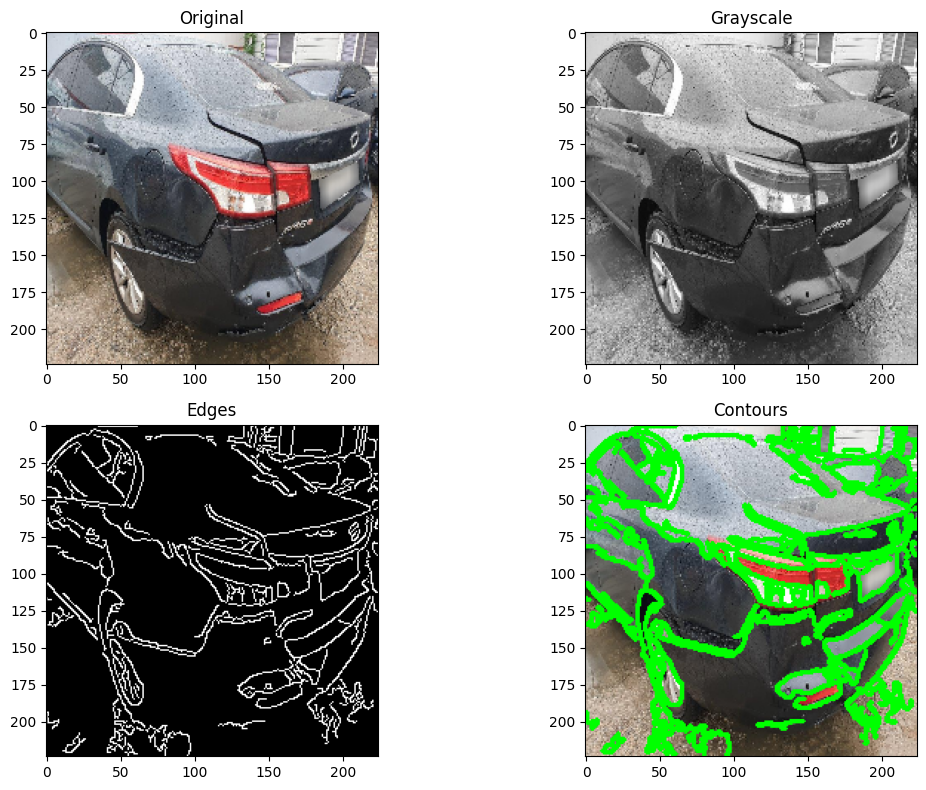


Generating feature maps...
Error during visualization: The layer sequential_2 has never been called and thus has no defined input.
Error details: The layer sequential_2 has never been called and thus has no defined input.


In [ ]:
"""
# Cell 9: Analyze a single image
# Run this cell when you want to analyze a specific image
if 'model' in locals():
    image_path = input("Enter the path to the image: ")
    if os.path.exists(image_path):
        print("\nApplying edge detection to visualize damage...")
        edge_detection_visualization(image_path)
        
        print("\nGenerating feature maps...")
        try:
            # Call the model with a dummy input to ensure it's been built
            # This fixes the "never been called" error
            dummy_img = np.zeros((1, IMG_HEIGHT, IMG_WIDTH, 3))
            _ = model(dummy_img)
            
            # Now call your original visualization function
            visualize_feature_maps(model, image_path)
            
            print("\nGenerating Grad-CAM visualization...")
            predicted_class = gradcam_visualization(model, image_path)
            print(f"\nPredicted class: {predicted_class}")
        except Exception as e:
            print(f"Error during visualization: {e}")
            print(f"Error details: {str(e)}")
            
            # If the error is about accessing layer indices, try this fallback
            if "index out of range" in str(e) or "out of range" in str(e):
                print("Trying alternative approach...")
                try:
                    # Create a simpler intermediate model with the first layer
                    img = load_and_preprocess_image(image_path)
                    img = np.expand_dims(img, axis=0)  # Add batch dimension
                    
                    if hasattr(model, 'layers') and len(model.layers) > 0:
                        print(f"Available layers: {[layer.name for layer in model.layers]}")
                        # Try with the first layer instead
                        intermediate_layer_model = tf.keras.Model(
                            inputs=model.input,
                            outputs=model.layers[0].output
                        )
                        feature_maps = intermediate_layer_model.predict(img)
                        
                        # Plot basic feature maps
                        plt.figure(figsize=(15, 12))
                        plt.subplot(4, 4, 1)
                        plt.imshow(img[0])
                        plt.title('Original Image')
                        plt.axis('off')
                        
                        # Plot some feature maps (if shape allows)
                        if len(feature_maps.shape) == 4:
                            num_maps = min(15, feature_maps.shape[-1])
                            for i in range(num_maps):
                                plt.subplot(4, 4, i+2)
                                plt.imshow(feature_maps[0, :, :, i], cmap='viridis')
                                plt.title(f'Feature Map {i+1}')
                                plt.axis('off')
                            plt.tight_layout()
                            plt.show()
                        else:
                            print(f"Feature maps have unexpected shape: {feature_maps.shape}")
                except Exception as nested_e:
                    print(f"Alternative approach also failed: {nested_e}")
                    print("Unable to visualize feature maps with the current model structure.")
    else:
        print(f"Error: File '{image_path}' not found.")
        
"""       


Applying edge detection to visualize damage...


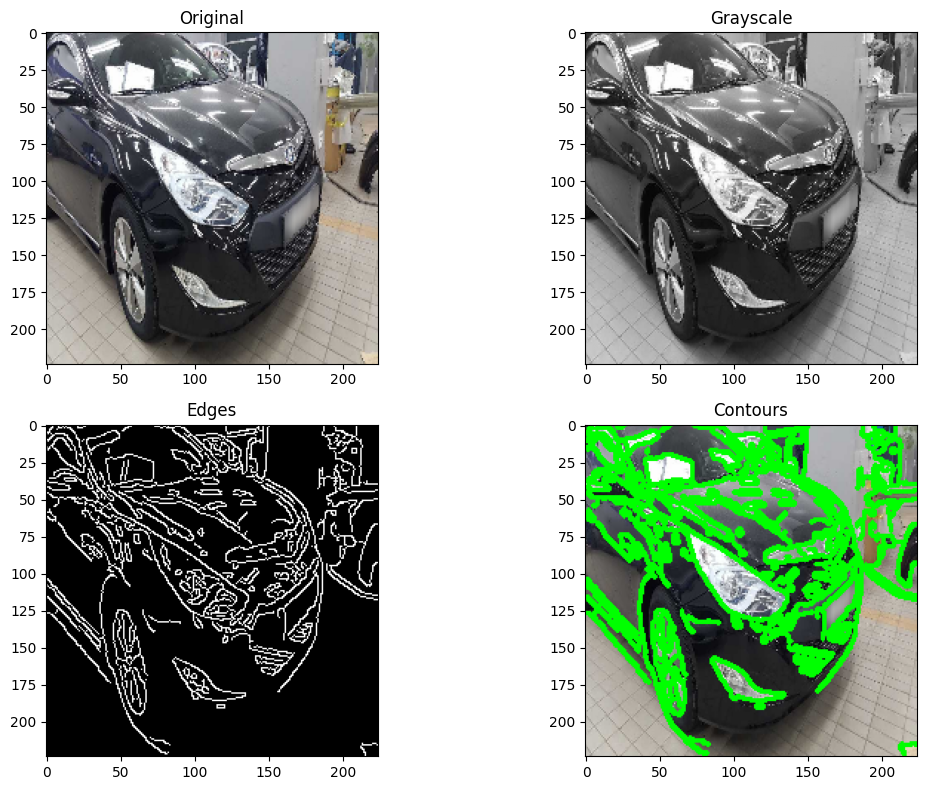


Generating feature maps...
Error during visualization: The layer sequential_2 has never been called and thus has no defined input.
Error details: The layer sequential_2 has never been called and thus has no defined input.


In [ ]:
# Cell 9: Analyze a single image
# Run this cell when you want to analyze a specific image
if 'model' in locals():
    image_path = input("Enter the path to the image: ")
    
    if os.path.exists(image_path):
        print("\nApplying edge detection to visualize damage...")
        edge_detection_visualization(image_path)

        try:
            # Load and preprocess image
            img = load_and_preprocess_image(image_path)
            img = np.expand_dims(img, axis=0)  # Add batch dimension

            # Force model to build if not already built
            _ = model(img)

            print("\nGenerating feature maps...")
            visualize_feature_maps(model, image_path)

            print("\nGenerating Grad-CAM visualization...")
            predicted_class = gradcam_visualization(model, image_path)
            print(f"\nPredicted class: {predicted_class}")

        except Exception as e:
            print(f"Error during visualization: {e}")
            print(f"Error details: {str(e)}")

            # If the error is about accessing layer indices, try this fallback
            if "index out of range" in str(e) or "out of range" in str(e):
                print("Trying alternative approach...")
                try:
                    if hasattr(model, 'layers') and len(model.layers) > 0:
                        print(f"Available layers: {[layer.name for layer in model.layers]}")
                        
                        intermediate_layer_model = tf.keras.Model(
                            inputs=model.input,
                            outputs=model.layers[0].output
                        )
                        feature_maps = intermediate_layer_model.predict(img)

                        # Plot basic feature maps
                        plt.figure(figsize=(15, 12))
                        plt.subplot(4, 4, 1)
                        plt.imshow(img[0])
                        plt.title('Original Image')
                        plt.axis('off')

                        # Plot some feature maps (if shape allows)
                        if len(feature_maps.shape) == 4:
                            num_maps = min(15, feature_maps.shape[-1])
                            for i in range(num_maps):
                                plt.subplot(4, 4, i+2)
                                plt.imshow(feature_maps[0, :, :, i], cmap='viridis')
                                plt.title(f'Feature Map {i+1}')
                                plt.axis('off')
                            plt.tight_layout()
                            plt.show()
                        else:
                            print(f"Feature maps have unexpected shape: {feature_maps.shape}")
                except Exception as nested_e:
                    print(f"Alternative approach also failed: {nested_e}")
                    print("Unable to visualize feature maps with the current model structure.")
    else:
        print(f"Error: File '{image_path}' not found.")
else:
    print("No model loaded. Please train or load a model first.")

